In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from datetime import datetime

In [ ]:
# Load time series data
data =  pd.read_csv("/content/drive/MyDrive/ARIMA modeling/Meteorological_Data.csv")

In [ ]:
# data.head()

In [ ]:
def get_data_by_freq(data, frequency="H"): # "H" by hour, "D" by day, "M" by month
  return data[~data.index.duplicated(keep='first')].asfreq(freq=frequency)

def prep_data(data):
  data['DATETIME'] = pd.to_datetime(data['DATETIME'])
  data.set_index('DATETIME', inplace=True)
  return data, get_data_by_freq(data=data['Avg Global CMP22 (vent/cor) [W/m^2]'], frequency="H").ffill() # "H" by hour, "D" by day, "M" by month

In [ ]:
data, ts_data = prep_data(data)

In [ ]:
# ts_data
# data

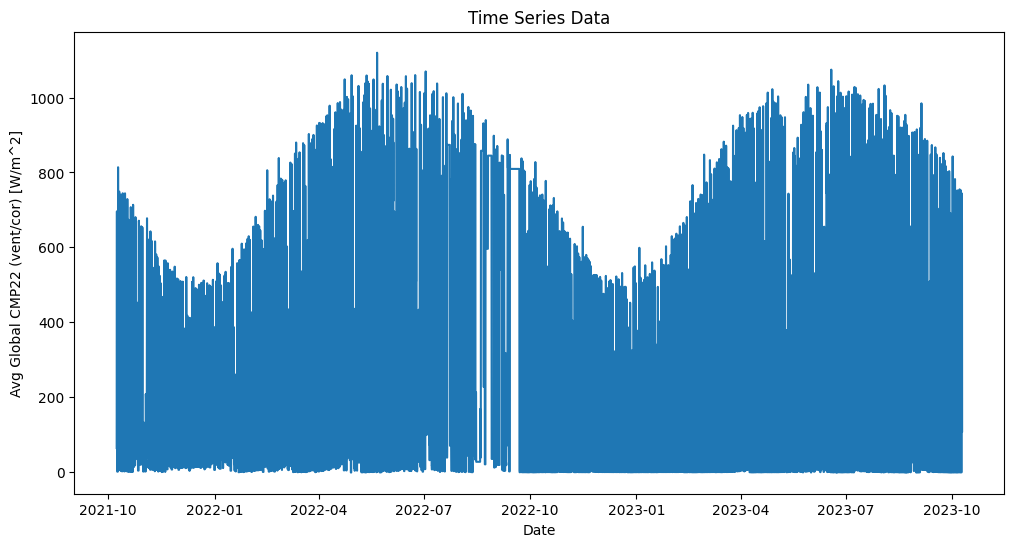

In [ ]:
# ts_data = data['Avg Global CMP22 (vent/cor) [W/m^2]']
plt.figure(figsize=(12, 6))
plt.plot(ts_data)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Avg Global CMP22 (vent/cor) [W/m^2]')
plt.show()

In [ ]:
# ts_data = get_data_by_freq(data['Avg Global CMP22 (vent/cor) [W/m^2]'])
# ts_data = ts_data[~ts_data.index.duplicated(keep='first')]
# ts_data = ts_data.asfreq(freq='H')  # Replace 'D' with the appropriate frequency, e.g., 'D' for daily data
# ts_data

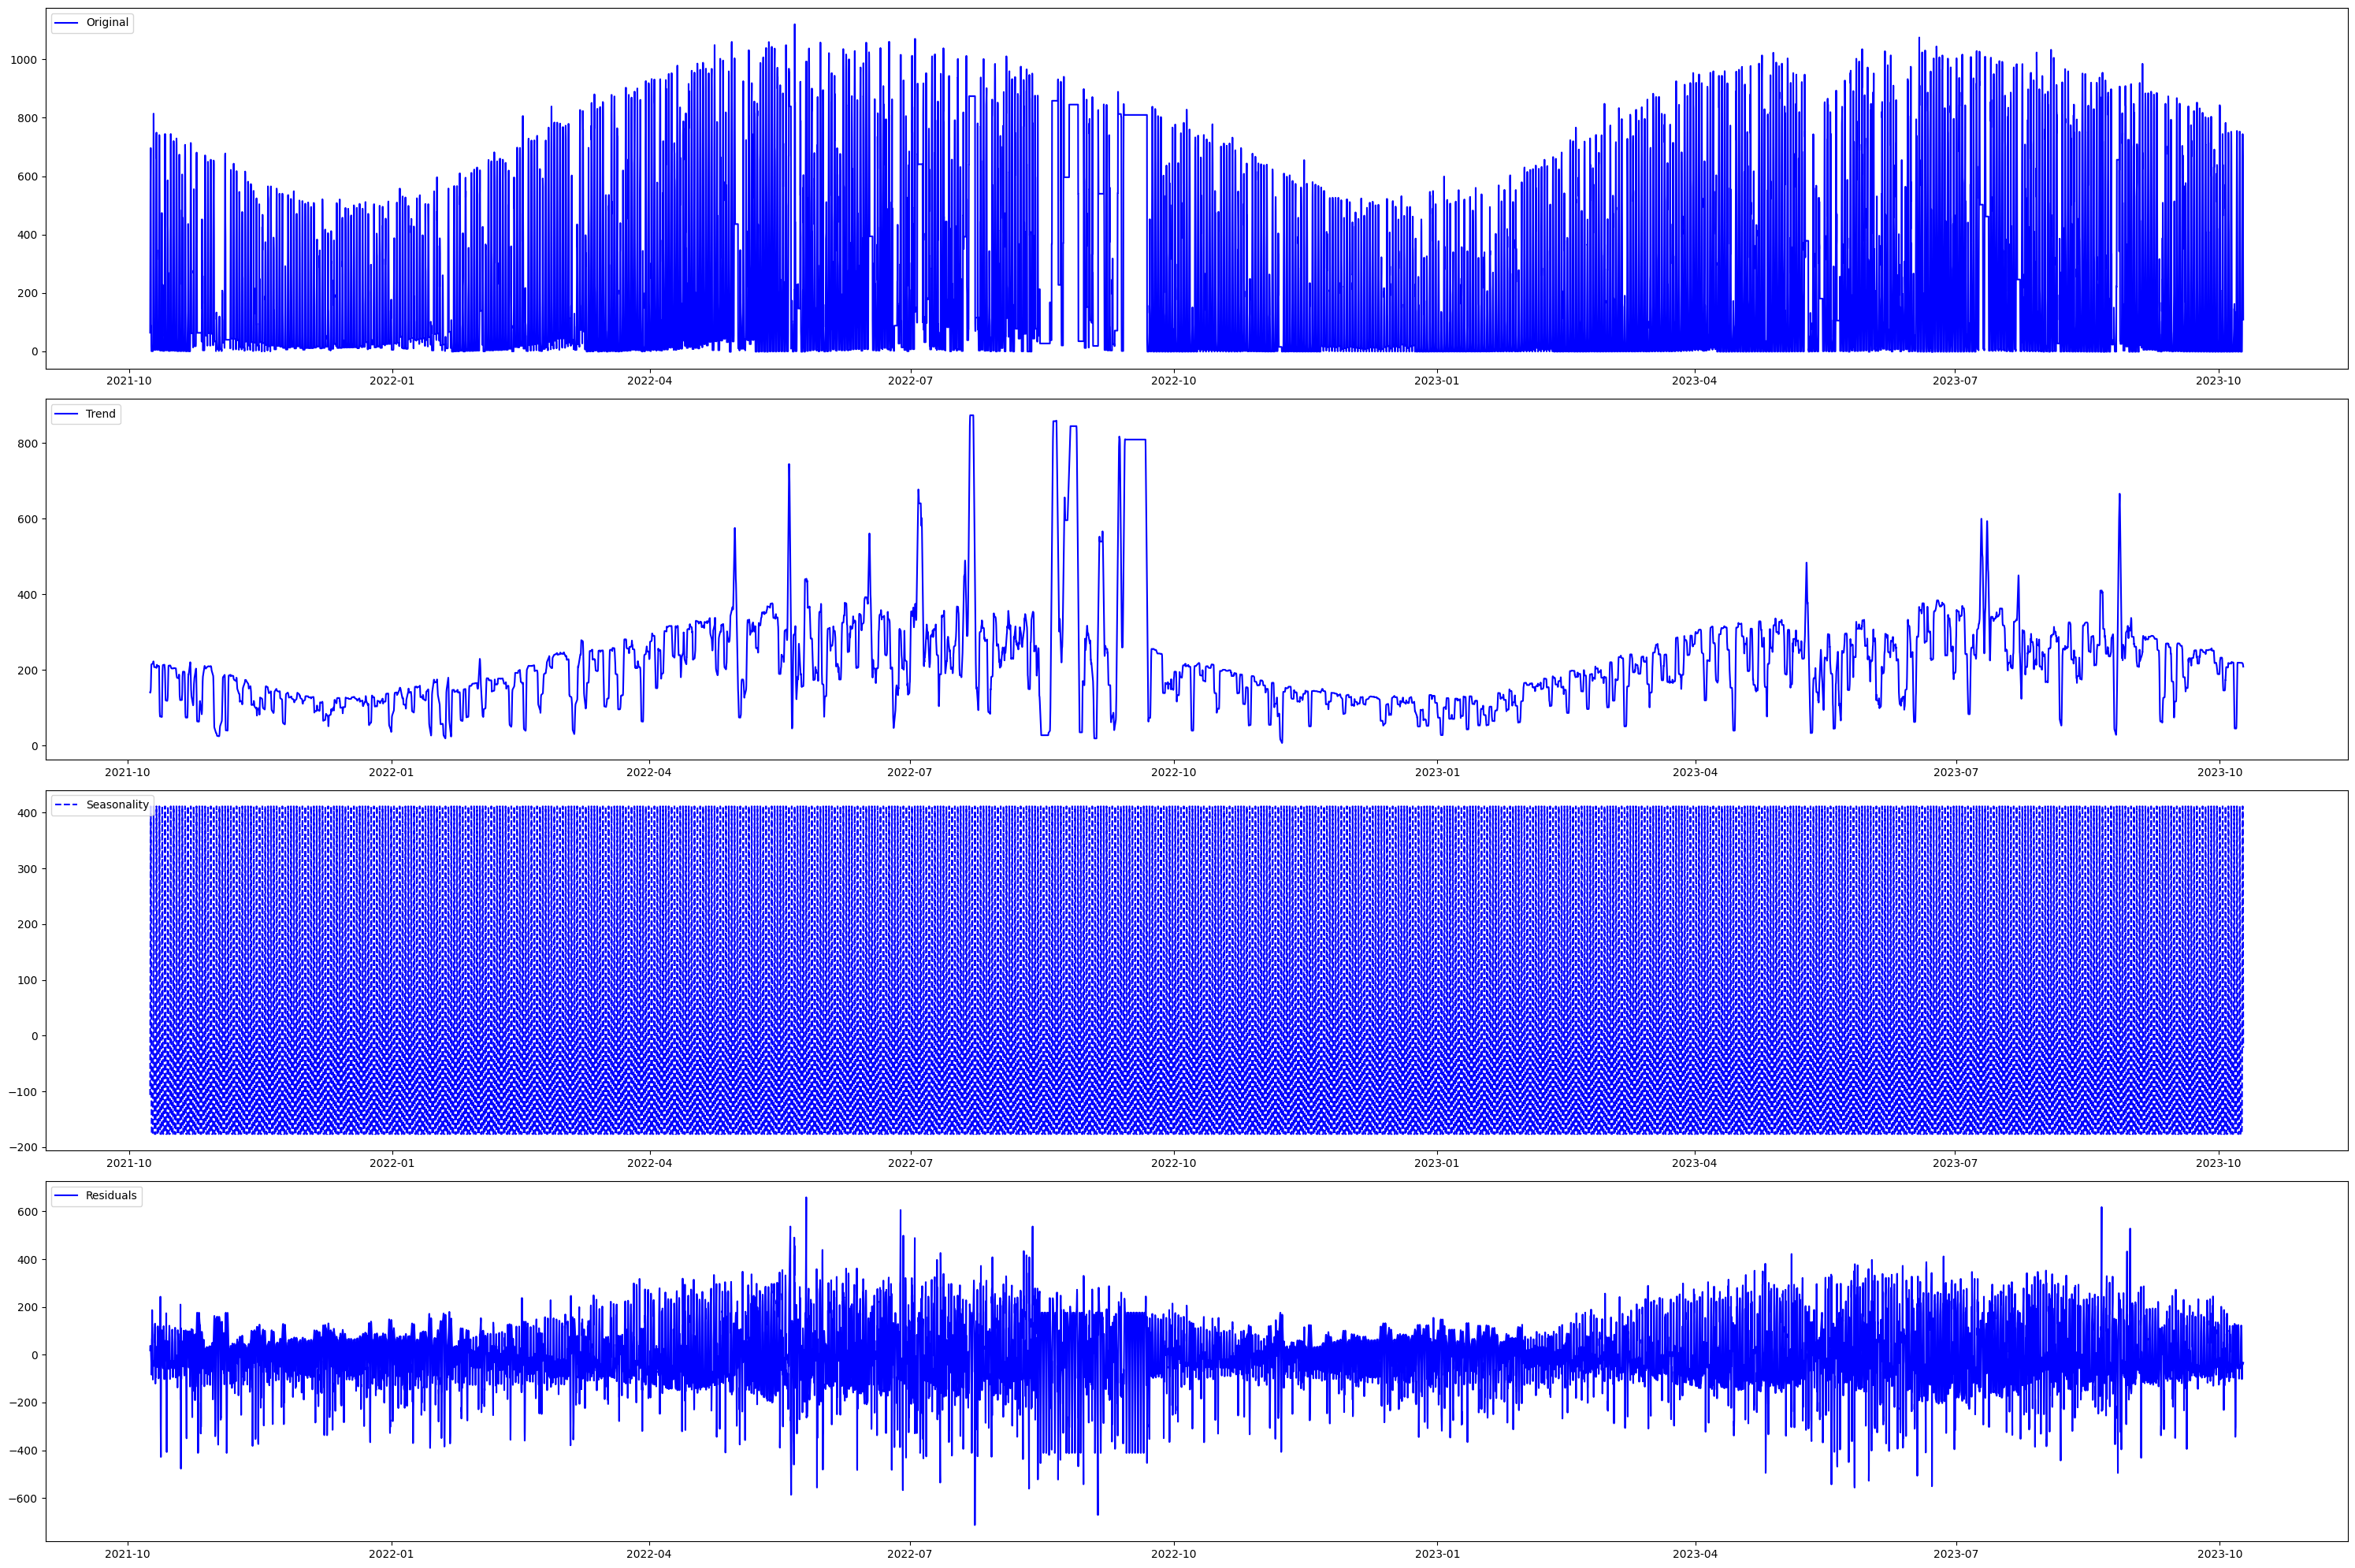

In [ ]:
decomposition = seasonal_decompose(ts_data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(30, 20))
plt.subplot(411)
# plt.plot(ts_data, "o", label='Original', color='blue', markersize=2)
plt.plot(ts_data, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, "--", label='Seasonality', color='blue', markersize=2)
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()


In [ ]:
# checking for stationary data
#h0 (NULL HYPOTHESIS): data is non-stationary
#h1: data is stationary

def adfuller_test(data):
    result=adfuller(data)

    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("\nWeak evidence against null hypothesis,indicating it is non-stationary ")

In [ ]:
ts_df = pd.DataFrame(ts_data)
adfuller_test(ts_df["Avg Global CMP22 (vent/cor) [W/m^2]"])

ADF Test Statistic : -9.564877647334654
p-value : 2.3717905147478287e-16
#Lags Used : 44
Number of Observations : 17510

Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


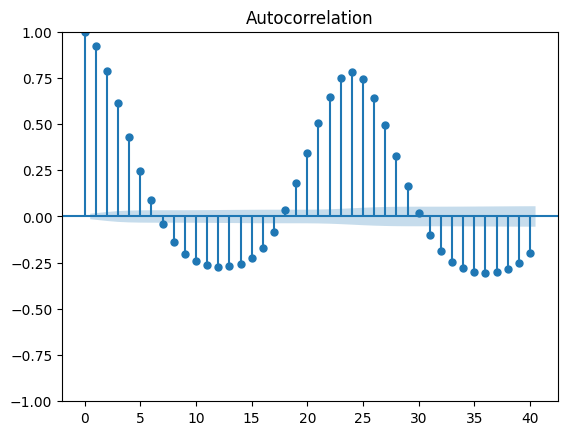

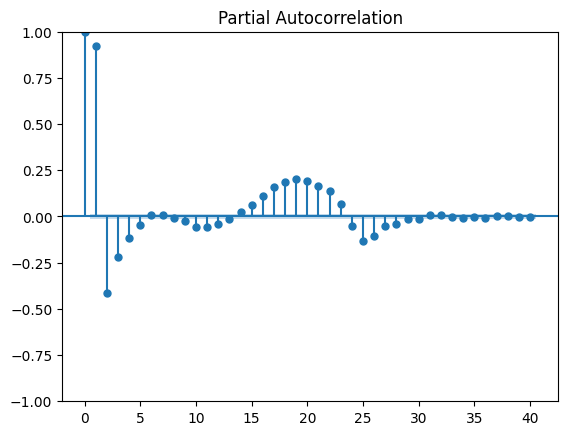

In [ ]:
plot_acf(ts_df, lags=40)
plot_pacf(ts_df, lags=40)
plt.show()

In [ ]:
def train_ARIMA(data, p, d, q, n_splits):
  tscv = TimeSeriesSplit(n_splits=n_splits) # Create a TimeSeriesSplit object
  rmse_scores=[]
  mse_scores=[]

  for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # Fit the ARIMA model on the training data
    model = ARIMA(train_data, order=(p, d, q))
    results = model.fit()

    # Make predictions on the test data
    predictions = results.forecast(steps=len(test_data))

    # Calculate Mean Squared Error (MSE) as the evaluation metric
    mse = mean_squared_error(test_data, predictions)
    mse_scores.append(mse)

    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
  return results, results.aic, results.bic, np.mean(mse_scores), np.mean(rmse_scores)

In [ ]:
global models_df

In [ ]:
def tuning_ARIMA(data,p,d,q):
  global models_df
  models_df = pd.DataFrame(columns=["model_num","(p,d,q)","aic","bic","avg_mse","avg_rmse"])
  model_count = 0

  for p_val in p:
    for d_val in d:
      for q_val in q:
        print(f"Model {model_count} params:")
        model_res, aic, bic, average_mse, average_rmse= train_ARIMA(data, p_val, d_val, q_val, n_splits=5)
        models_df.loc[model_count]=[model_count,(p_val,d_val,q_val),aic,bic,average_mse,average_rmse]
        print(f"p: {p_val}\td: {d_val}\tq: {q_val}\taic: {aic}\tbic: {bic}\tAverage MSE: {average_mse}\tAverage RMSE: {average_rmse}")

        if min(models_df["aic"])>=aic:
          print("Saving model by AIC score")
          model_filename = '/content/drive/MyDrive/Forecasting Models/ARIMA/BASE_ARIMA_model.pkl' # +'_'+str(model_count)+'.pkl'

          # Save the ARIMA model to a file
          with open(model_filename, 'wb') as model_file:
              pickle.dump(model_res, model_file)

        models_df.to_csv('/content/drive/MyDrive/Forecasting Models/ARIMA/ARIMA_model_tuning.csv', index=False)
        model_count+=1
  return models_df

In [ ]:
"""
uncomment code below to perform hyperparameter tuning
"""
# tuning ARIMA model
# p = [12]
# d = [0]
# q = [1]
# models_df = tuning_ARIMA(ts_data,p,d,q)

'\nuncomment code below to perform hyperparameter tuning\n'

In [ ]:
def plot_forecast(model, forecast_steps, plot_title):
  # Now you can use the loaded model for predictions
  # forecast_steps = steps
  forecast = model.get_forecast(steps=forecast_steps)
  # Get the forecasted values and confidence intervals
  forecast_values = forecast.predicted_mean
  confidence_intervals = forecast.conf_int()

  # Plot the forecasted values and confidence intervals
  plt.figure(figsize=(12, 6))
  plt.plot(ts_data ,'o', label='Observed', color='blue', markersize=2)
  plt.plot(forecast_values,'x', label='Forecast', color='red', markersize=2, alpha=0.3)
  plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
  plt.title(plot_title)
  plt.xlabel('Time')
  plt.ylabel('Solar Irradiance')
  plt.legend()
  plt.show()

def plot_predictions(model, start_date, end_date, plot_title, flag=0):
  # Now you can use the loaded model for predictions
  # forecast_steps = steps
  if flag==0:
    predictions = model.get_prediction()
  if flag==1:
    predictions = model.get_prediction(start=start_date, end=end_date)
  # Get the forecasted values and confidence intervals
  forecast_values = predictions.predicted_mean
  confidence_intervals = predictions.conf_int()

  # Plot the forecasted values and confidence intervals
  plt.figure(figsize=(12, 6))
  plt.plot(ts_data ,'o', label='Observed', color='blue', markersize=2)
  plt.plot(forecast_values,'x', label='Forecast', color='red', markersize=2)
  plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
  plt.title(plot_title)
  plt.xlabel('Time')
  plt.ylabel('Solar Irradiance')
  plt.legend()
  plt.show()

In [ ]:
#BASE MODEL
model_filename = '/content/drive/MyDrive/Forecasting Models/ARIMA/BASE_ARIMA.pkl' #1,0,1
# Load the ARIMA model from a file
with open(model_filename, 'rb') as model_file:
    loaded_BASE_arima_model = pickle.load(model_file)

MAE:  94.99329085394442


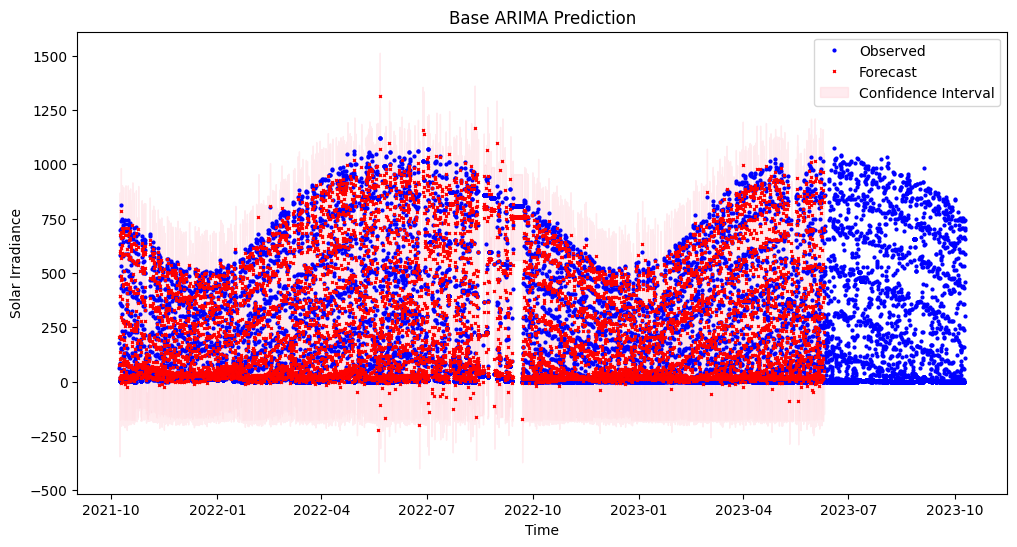

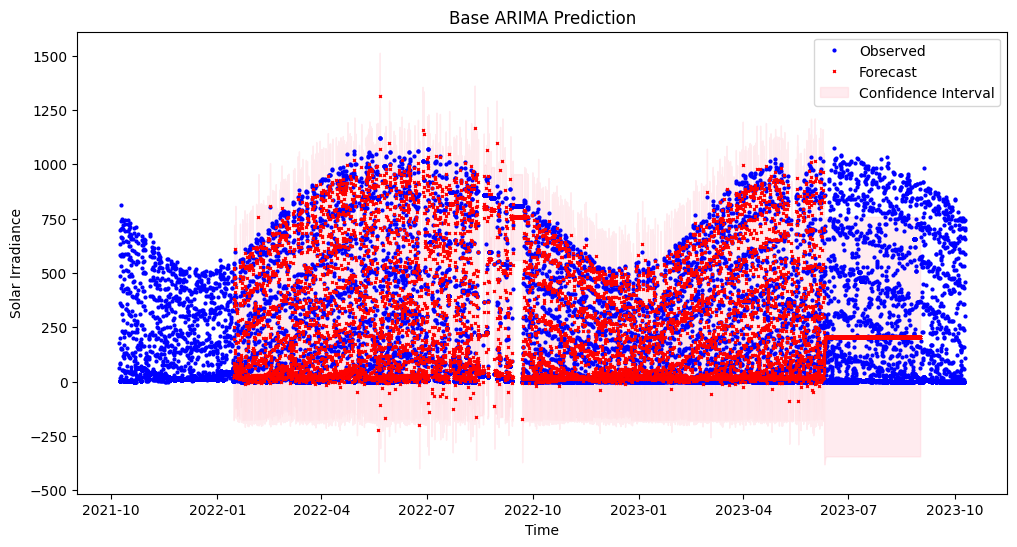

In [ ]:
# plotting predictions
start_date = datetime(2022, 1, 15)
end_date = datetime(2023, 9, 1)
predictions = loaded_BASE_arima_model.predict(start=0, end=len(ts_data)-1)
mae = mean_absolute_error(ts_data, predictions)
print("MAE: ",mae)
title="Base ARIMA Prediction"
plot_predictions(loaded_BASE_arima_model, start_date, end_date, title, flag=0)
plot_predictions(loaded_BASE_arima_model, start_date, end_date, title, flag=1)

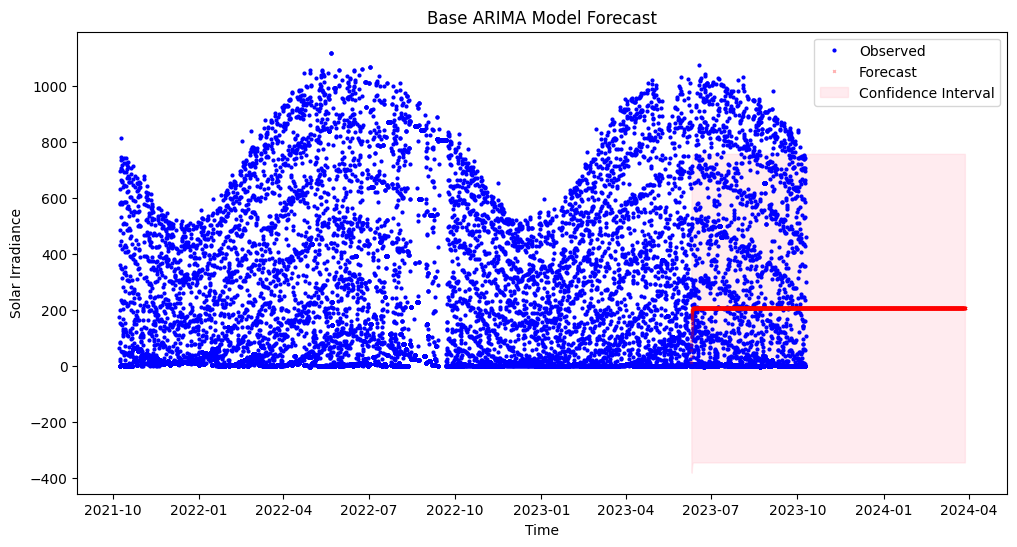

In [ ]:
# plotting forecast
steps=7000
title="Base ARIMA Model Forecast"
plot_forecast(loaded_BASE_arima_model, steps, title)

In [ ]:
# INTERMEDIATE MODEL
model_filename = '/content/drive/MyDrive/Forecasting Models/ARIMA/INTER_ARIMA.pkl' #3,1,15
# Load the ARIMA model from a file
with open(model_filename, 'rb') as model_file:
    loaded_INTER_arima_model = pickle.load(model_file)

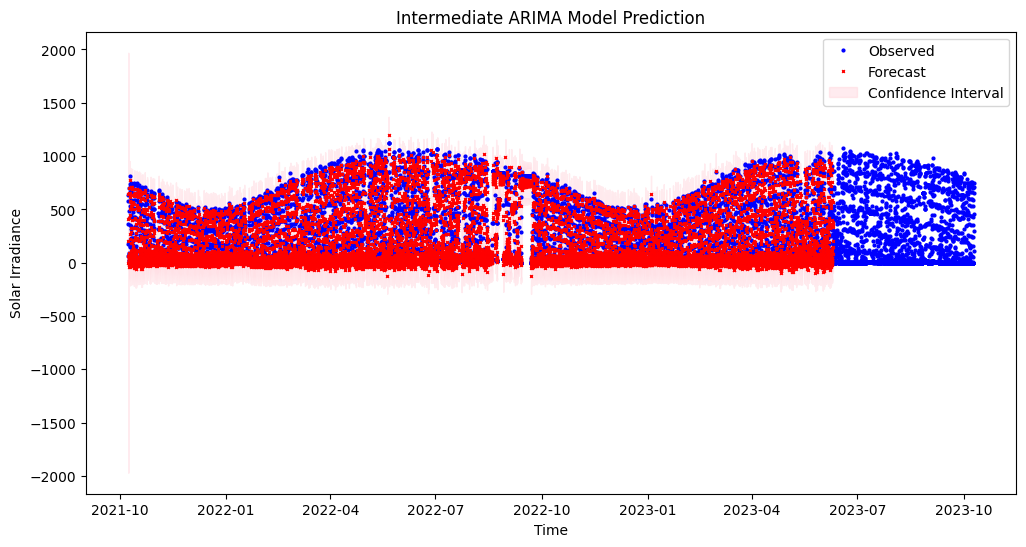

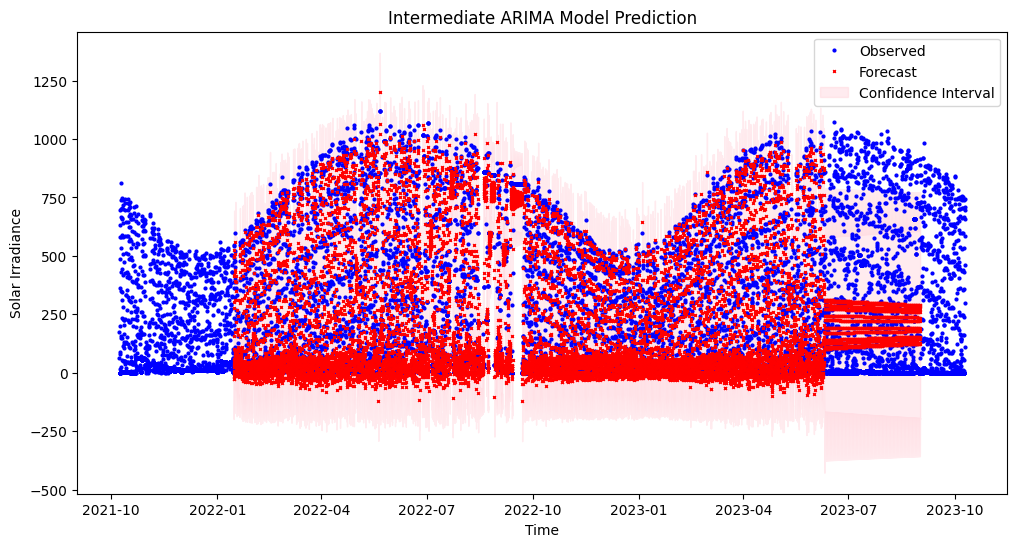

In [ ]:
# plotting predictions
start_date = datetime(2022, 1, 15)
end_date = datetime(2023, 9, 1)
title="Intermediate ARIMA Model Prediction"
plot_predictions(loaded_INTER_arima_model, start_date, end_date, title, flag=0)
plot_predictions(loaded_INTER_arima_model, start_date, end_date, title, flag=1)

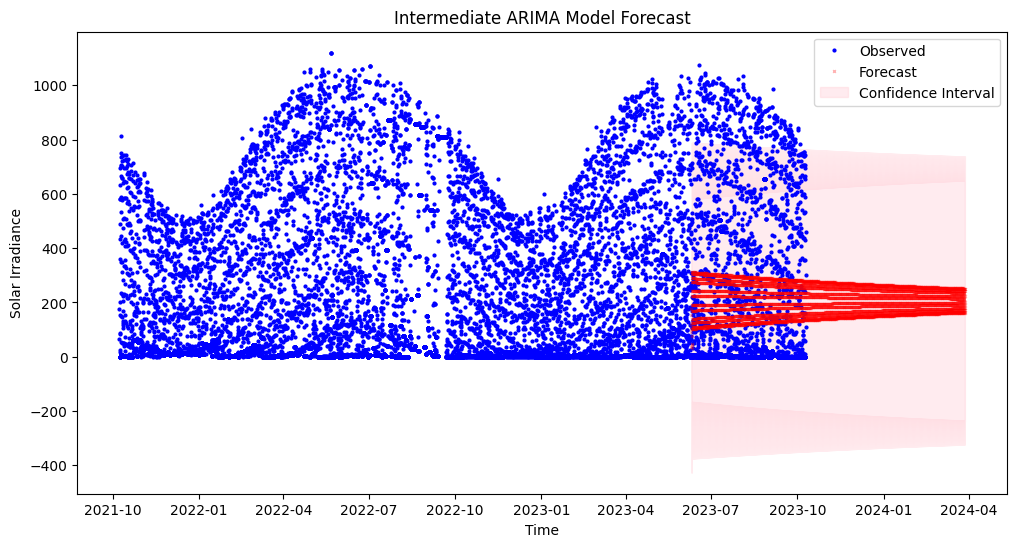

In [ ]:
# plotting forecast
steps=7000
title="Intermediate ARIMA Model Forecast"
plot_forecast(loaded_INTER_arima_model, steps, title)

In [ ]:
model_filename = '/content/drive/MyDrive/Forecasting Models/ARIMA/FINAL_ARIMA.pkl' #6,0,15
# Load the ARIMA model from a file
with open(model_filename, 'rb') as model_file:
    loaded_arima_model = pickle.load(model_file)

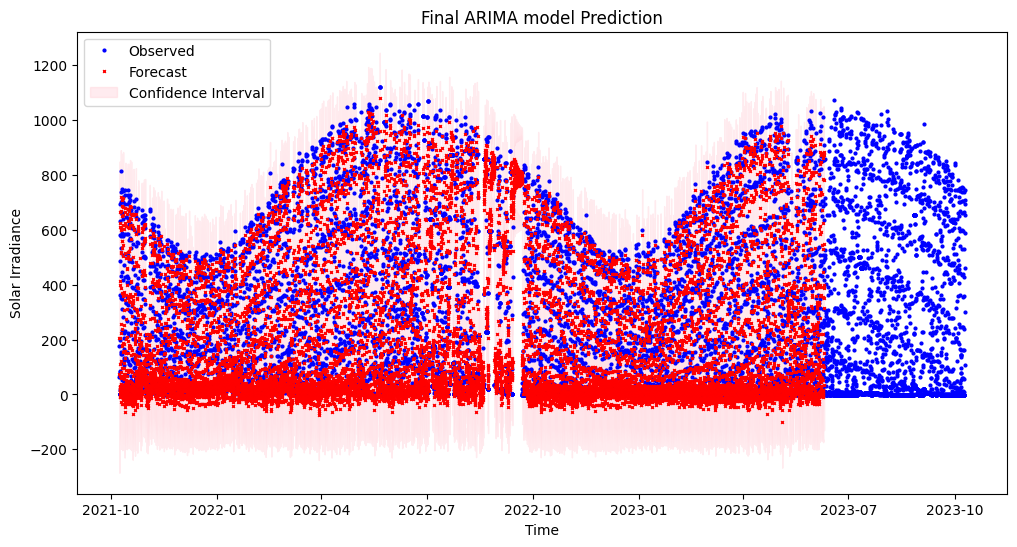

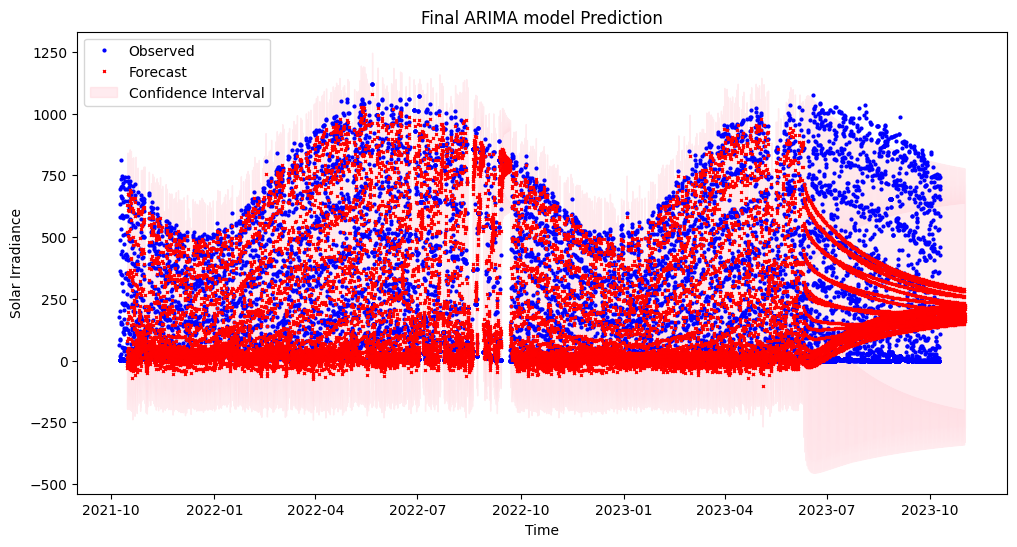

In [ ]:
# plotting predictions
start_date = datetime(2021, 10, 15)
end_date = datetime(2023, 11, 1)
title="Final ARIMA model Prediction"
plot_predictions(loaded_arima_model, start_date, end_date, title, flag=0)
plot_predictions(loaded_arima_model, start_date, end_date, title, flag=1)

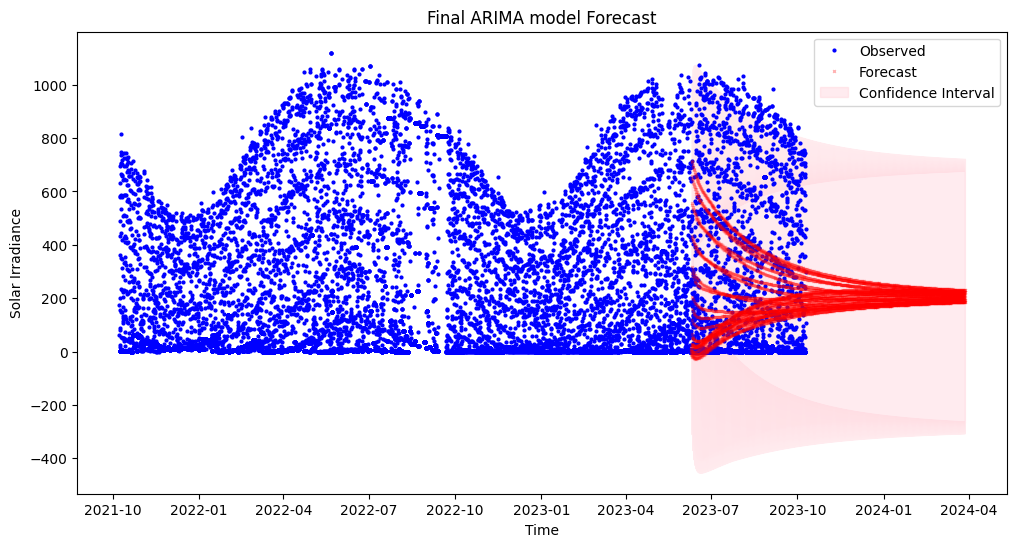

In [ ]:
# plotting forecast
steps=7000
title="Final ARIMA model Forecast"
plot_forecast(loaded_arima_model, steps, title)

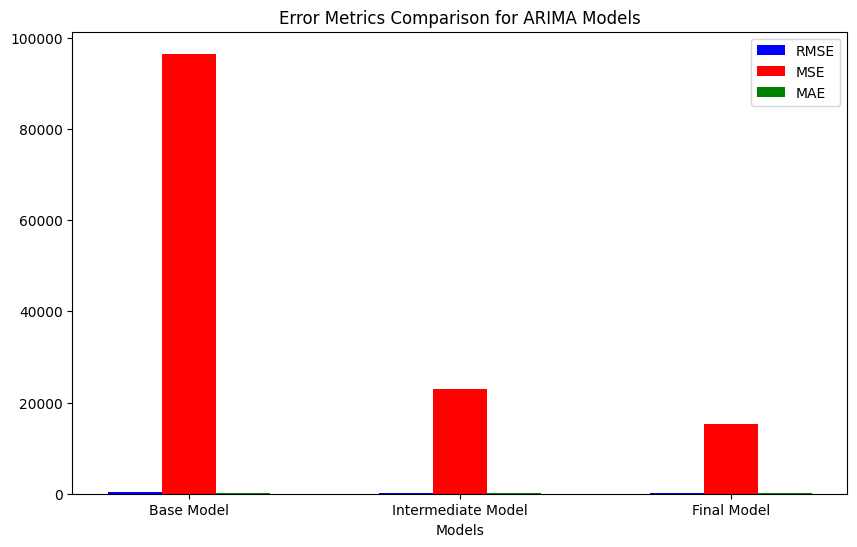

In [ ]:
models = ['Base Model', 'Intermediate Model', 'Final Model']
rmse_values = [306.3807, 151.4939, 123.3834]
mse_values = [96510.5513, 22950.3893, 15223.4684]
mae_values = [94.9932, 90.6608,71.9053]

bar_width = 0.2
index = range(len(models))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot RMSE
rmse_bars = ax.bar(index, rmse_values, bar_width, label='RMSE', color='blue')

# Plot MSE
mse_bars = ax.bar([i + bar_width for i in index], mse_values, bar_width, label='MSE', color='red')

# Plot MAE
mae_bars = ax.bar([i + 2 * bar_width for i in index], mae_values, bar_width, label='MAE', color='green')

# Set the x-axis labels and title
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(models)
ax.set_xlabel('Models')
ax.set_title('Error Metrics Comparison for ARIMA Models')

# Add a legend
ax.legend()

# Show the plot
plt.show()

#SARIMAX

In [ ]:
target_data = data['Avg Global CMP22 (vent/cor) [W/m^2]']
target_data = target_data[~target_data.index.duplicated(keep='first')]
target_data = target_data.asfreq(freq='H')
target_data=target_data.ffill()
target_data

DATETIME
2021-10-08 07:00:00     63.8407
2021-10-08 08:00:00    176.1522
2021-10-08 09:00:00    361.7695
2021-10-08 10:00:00    582.2481
2021-10-08 11:00:00    632.4995
                         ...   
2023-10-09 13:00:00    707.7538
2023-10-09 14:00:00    655.9580
2023-10-09 15:00:00    459.6153
2023-10-09 16:00:00    299.7559
2023-10-09 17:00:00    108.7152
Freq: H, Name: Avg Global CMP22 (vent/cor) [W/m^2], Length: 17555, dtype: float64

In [ ]:
feature_columns = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Blue/Red_min','Avg Albedo (CMP11)','Avg Moisture','Avg Avg Wind Speed @ 6ft [m/s]','Avg Tower Dew Point Temp [deg C]','Avg Total Cloud Cover [%]','Avg Opaque Cloud Cover [%]','Avg BRBG Total Cloud Cover [%]']

exogenous_data=data[feature_columns]
exogenous_data = exogenous_data[~exogenous_data.index.duplicated(keep='first')]
exogenous_data=exogenous_data.asfreq(freq='H')
exogenous_data=exogenous_data.ffill()
exogenous_data.tail()

Avg Zenith Angle [degrees]  Avg Sun Flag  \
DATETIME                                                        
2023-10-09 13:00:00                     47.3141        3.6667   
2023-10-09 14:00:00                     51.9659        3.3333   
2023-10-09 15:00:00                     59.5057        3.0000   
2023-10-09 16:00:00                     68.9424        5.0000   
2023-10-09 17:00:00                     79.5027        6.2000   

                     Avg Blue/Red_min  Avg Albedo (CMP11)  Avg Moisture  \
DATETIME                                                                  
2023-10-09 13:00:00            0.9117              0.1926           0.0   
2023-10-09 14:00:00            0.8933              0.2005           0.0   
2023-10-09 15:00:00            0.8750              0.2061           0.0   
2023-10-09 16:00:00            0.9083              0.2027           0.0   
2023-10-09 17:00:00            0.8940              0.1709           0.0   

                     Avg Avg Wind Speed @ 6ft [m/s]  \
DATETIME                                              
2023-10-09 13:00:00                          2.3381   
2023-10-09 14:00:00                          2.2920   
2023-10-09 15:00:00                          2.3481   
2023-10-09 16:00:00                          1.7495   
2023-10-09 17:00:00                          1.0690   

                     Avg Tower Dew Point Temp [deg C]  \
DATETIME                                                
2023-10-09 13:00:00                           -2.6921   
2023-10-09 14:00:00                           -3.2820   
2023-10-09 15:00:00                           -3.5913   
2023-10-09 16:00:00                           -3.8666   
2023-10-09 17:00:00                           -3.6417   

                     Avg Total Cloud Cover [%]  Avg Opaque Cloud Cover [%]  \
DATETIME                                                                     
2023-10-09 13:00:00                    18.6667                      9.8667   
2023-10-09 14:00:00                    20.0833                     11.8500   
2023-10-09 15:00:00                    35.1000                     23.3667   
2023-10-09 16:00:00                    42.9000                     30.9333   
2023-10-09 17:00:00                    49.7667                     33.7333   

                     Avg BRBG Total Cloud Cover [%]  
DATETIME                                             
2023-10-09 13:00:00                          3.6667  
2023-10-09 14:00:00                         17.1667  
2023-10-09 15:00:00                         24.5000  
2023-10-09 16:00:00                         38.6667  
2023-10-09 17:00:00                         39.0000

In [ ]:
# p, d, and q values based on the ACF and PACF plots
p, d, q = 1, 0, 1  # Replace with your chosen p, d, q values
P, D, Q, s = 18, 0, 24, 6 # Replace with your chosen seasonal p, d, q, and seasonality
model_s = SARIMAX(endog=target_data, exog=exogenous_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
results_s = model_s.fit()

# Make predictions on the test data
predictions = results_s.predict(start=test_index[0], end=test_index[-1])

# Calculate Mean Squared Error (MSE) as the evaluation metric
mse = mean_squared_error(target_data, predictions)
rmse = np.sqrt(mse)

seasonalmodel = SARIMAX(ts_data, order=(p, d, q), seasonal=(p, d, q, 24*365))
sarima = seasonalmodel.fit()

model_filename = 'SARIMAX_model2.pkl'
# Save the ARIMA model to a file
with open(model_filename, 'wb') as model_file:
    pickle.dump(sarima, model_file)

print("AIC Score: ", sarima.aic)
print("BIC Score: ", sarima.bic)
print("MSE Score: ", mse)
print("RMSE Score: ", rmse)

In [ ]:
model_filename = 'SARIMAX_model2.pkl' #6,0,15
# Load the ARIMA model from a file
with open(model_filename, 'rb') as model_file:
    loaded_sarima_model = pickle.load(model_file)

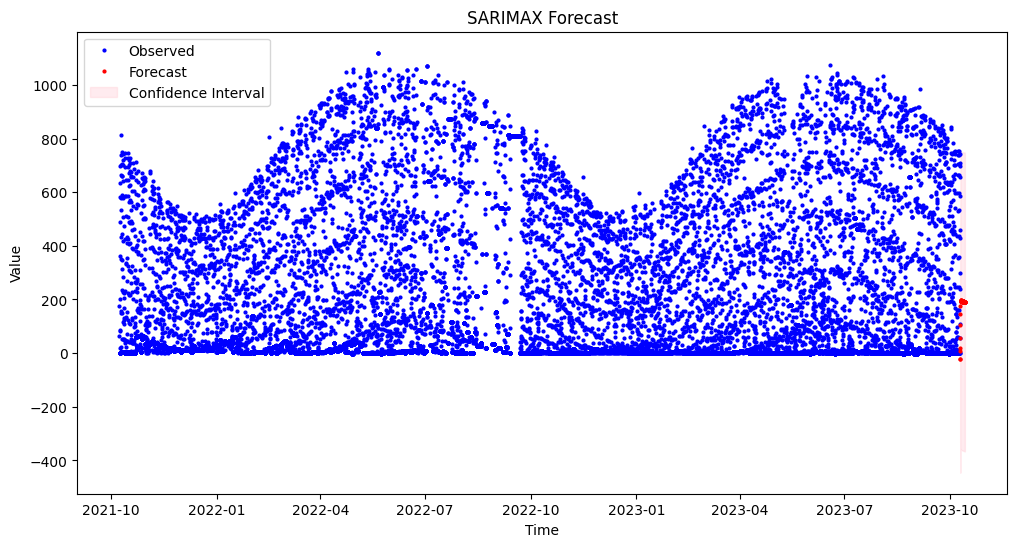

In [ ]:
# plotting predictions
start_date = datetime(2022, 1, 15)
end_date = datetime(2023, 9, 1)
title="ARIMA Prediction"
plot_predictions(loaded_sarima_model, start_date, end_date, title, flag=0)
plot_predictions(loaded_sarima_model, start_date, end_date, title, flag=1)

# plotting forecast
steps=7000
title="SARIMAX Forecast"
plot_forecast(loaded_sarima_model, steps, title)